# Importing & Loading Dependencies

In [1]:
!pip install monai

import nibabel as nib
from monai.transforms import LoadImage, Compose, NormalizeIntensityd, RandSpatialCropd, RandFlipd, \
                             RandRotate90d, Rand3DElasticd, RandAdjustContrastd, CenterSpatialCropd,\
                             Resized, RandRotated, RandZoomd, RandGaussianNoised, Spacingd, RandShiftIntensityd,  CropForegroundd, SpatialPadd, AsDiscrete, GridPatchd\

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
import logging
import numpy as np
import os
import random
from typing import Optional, Sequence, Tuple, Union
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import interpolate
import pdb

from monai.networks.blocks.convolutions import Convolution
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.utils import get_act_layer, get_norm_layer

from pathlib import Path
import argparse
import json
import math
import os
import random
import signal
import subprocess
import sys
import time
import pdb
import logging
from ipywidgets import interact, IntSlider
from itertools import chain

from monai.losses import DiceLoss
from torch import nn, optim
from tqdm import tqdm
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.7 MB/s eta 0:00:00


# Creating Dataset with Preprocessing

In [2]:
class CustomDataset3D(Dataset):
    def __init__(self, data_dirs, patient_lists, mode):
        self.data_dirs = data_dirs
        self.patient_lists = patient_lists
        self.mode = mode

    @staticmethod
    def resize_with_aspect_ratio(keys, target_size):
        def transform(data):
            for key in keys:
                volume = data[key]
                original_shape = volume.shape[-3:]
    
                scaling_factor = min(
                    target_size[0] / original_shape[0],
                    target_size[1] / original_shape[1],
                    target_size[2] / original_shape[2]
                )
    
                new_shape = [
                    int(dim * scaling_factor) for dim in original_shape
                ]
    
                resize_transform = Resized(keys=[key], spatial_size=new_shape, mode="trilinear" if key == "imgs" else "nearest-exact")
                data = resize_transform(data)
    
                pad_transform = SpatialPadd(keys=[key], spatial_size=target_size, mode="constant")
                data = pad_transform(data)
            return data

        return transform

    def preprocess(cls, data, mode):
        if mode == 'training':
          transform = Compose([
            CropForegroundd(keys=["imgs", "masks"], source_key="imgs"),
            cls.resize_with_aspect_ratio(keys=["imgs", "masks"], target_size=[128, 128, 128]),
            NormalizeIntensityd( keys=['imgs'], nonzero=False, channel_wise=True),
              
            RandFlipd(keys=["imgs", "masks"],   
                    prob=0.5,                 
                    spatial_axis=2,  
            ),

            RandAdjustContrastd(
                keys=["imgs"],          
                prob=0.15,             
                gamma=(0.65, 1.5),   
            ),
            
        ])

        elif mode == 'validation':
          transform = Compose([
            CropForegroundd(keys=["imgs", "masks"], source_key="imgs"),
            cls.resize_with_aspect_ratio(keys=["imgs", "masks"], target_size=[128, 128, 128]),
            NormalizeIntensityd( keys=['imgs'], nonzero=False, channel_wise=True)

        ])

        else: # 'testing'
          transform = Compose([
            CropForegroundd(keys=["imgs", "masks"], source_key="imgs"),
            cls.resize_with_aspect_ratio(keys=["imgs", "masks"], target_size=[128, 128, 128]),
            NormalizeIntensityd( keys=['imgs'], nonzero=False, channel_wise=True)

        ])

        augmented_data = transform(data)
        return augmented_data
        
    def __len__(self):
        return len(self.patient_lists)

    def __getitem__(self, idx):
        patient_id = self.patient_lists[idx]
        loadimage = LoadImage(reader='NibabelReader', image_only=True)

        data_type=patient_id.split('-')[1]
        if data_type == 'GLI':
            patient_folder_path = os.path.join('/kaggle/input/bratsglioma/Training', patient_id)
        elif data_type == 'SSA':
            patient_folder_path = os.path.join('/kaggle/input/bratsafrica24', patient_id)
        elif data_type == 'PED':
            patient_folder_path = os.path.join('/kaggle/input/bratsped/Training', patient_id)
        elif data_type == 'MEN':
            patient_folder_path = os.path.join('/kaggle/input/bratsmen', patient_id)
        else:
            patient_folder_path = os.path.join('/kaggle/input/bratsmet24', patient_id)

        def resolve_file_path(folder, name):
            file_path = os.path.join(folder, name)
            if os.path.isdir(file_path):
                for root, _, files in os.walk(file_path):
                    for file in files:
                        if file.endswith(".nii"):
                            return os.path.join(root, file)
            return file_path

        t1c_path  = resolve_file_path(patient_folder_path, patient_id + '-t1c.nii')
        t1n_path  = resolve_file_path(patient_folder_path, patient_id + '-t1n.nii')
        t2f_path  = resolve_file_path(patient_folder_path, patient_id + '-t2f.nii')
        t2w_path  = resolve_file_path(patient_folder_path, patient_id + '-t2w.nii')
        seg_path  = os.path.join(patient_folder_path, patient_id + '-seg.nii')

        t1c_loader   = loadimage( t1c_path )
        t1n_loader   = loadimage( t1n_path )
        t2f_loader   = loadimage( t2f_path )
        t2w_loader   = loadimage( t2w_path )
        masks_loader = loadimage( seg_path )

        t1c_tensor   = torch.Tensor(t1c_loader).unsqueeze(0)
        t1n_tensor   = torch.Tensor(t1n_loader).unsqueeze(0)
        t2f_tensor   = torch.Tensor(t2f_loader).unsqueeze(0)
        t2w_tensor   = torch.Tensor(t2w_loader).unsqueeze(0)
        masks_tensor = torch.Tensor(masks_loader).unsqueeze(0)

        concat_tensor = torch.cat( (t1c_tensor, t1n_tensor, t2f_tensor, t2w_tensor, masks_tensor), 0 )
        data = {            
            'imgs'  : np.array(concat_tensor[0:4,:,:,:]),
            'masks' : np.array(concat_tensor[4:,:,:,:])
        }

        augmented_imgs_masks = self.preprocess(data, self.mode)
        imgs  = np.array(augmented_imgs_masks['imgs'])
        masks = np.array(augmented_imgs_masks['masks'])

        y = {
            'imgs'  : torch.from_numpy(imgs).type(torch.FloatTensor),
            'masks' : torch.from_numpy(masks).type(torch.FloatTensor),
            'patient_id' : patient_id,
            'data_type' : data_type
        }

        return y

# Data Loaders

In [3]:
def prepare_test_loader(args):
    test_datasets = []
    split_ratio = {'training': 0.71, 'validation': 0.09, 'testing': 0.2}
    
    for i, data_dir in enumerate(args['data_dirs']):
        patient_lists = os.listdir( data_dir )
        patient_lists.sort()
        total_patients = len(patient_lists)

        random.seed(5)
        random.shuffle(patient_lists)
    
        train_split = int(split_ratio['training'] * total_patients)
        val_split = int(split_ratio['validation'] * total_patients)    
        test_patient_lists = patient_lists[train_split + val_split :]

        test_patient_lists.sort()
        print(test_patient_lists)
        
        test_datasets.append(test_patient_lists)
        
    combined_testDataset = list(chain.from_iterable(test_datasets))
    print(f'Number of combined testing samples without aggregation', len(combined_testDataset))
    
    testDataset = CustomDataset3D( args['data_dirs'], combined_testDataset, mode='testing')
    
    testLoader = DataLoader(
        testDataset, batch_size=args['test_batch_size'], num_workers=args['workers'], prefetch_factor=2,
        pin_memory=True, shuffle=False)

    return testLoader

# DynUNet Model

In [4]:
class UnetBasicBlock(nn.Module):
    """
    A CNN module module that can be used for DynUNet, based on:
    `Automated Design of Deep Learning Methods for Biomedical Image Segmentation <https://arxiv.org/abs/1904.08128>`_.
    `nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation <https://arxiv.org/abs/1809.10486>`_.

    Args:
        spatial_dims: number of spatial dimensions.
        in_channels: number of input channels.
        out_channels: number of output channels.
        kernel_size: convolution kernel size.
        stride: convolution stride.
        norm_name: feature normalization type and arguments.
        act_name: activation layer type and arguments.
        dropout: dropout probability.

    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[Sequence[int], int],
        stride: Union[Sequence[int], int],
        norm_name: Union[Tuple, str] = ("INSTANCE", {"affine": True}),
        act_name: Union[Tuple, str] = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
        dropout: Optional[Union[Tuple, str, float]] = None,
    ):
        super().__init__()
        self.conv1 = get_conv_layer(
            spatial_dims,
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dropout=dropout,
            conv_only=True,
        )

        self.conv2 = get_conv_layer(
            spatial_dims,
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            dropout=dropout,
            conv_only=True
        )
        self.lrelu = get_act_layer(name=act_name)
        self.norm1 = get_norm_layer(name=norm_name, spatial_dims=spatial_dims, channels=out_channels)
        self.norm2 = get_norm_layer(name=norm_name, spatial_dims=spatial_dims, channels=out_channels)

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.norm1(out)
        out = self.lrelu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.lrelu(out)
        return out



class UnetUpBlock(nn.Module):
    """
    An upsampling module that can be used for DynUNet, based on:
    `Automated Design of Deep Learning Methods for Biomedical Image Segmentation <https://arxiv.org/abs/1904.08128>`_.
    `nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation <https://arxiv.org/abs/1809.10486>`_.

    Args:
        spatial_dims: number of spatial dimensions.
        in_channels: number of input channels.
        out_channels: number of output channels.
        kernel_size: convolution kernel size.
        stride: convolution stride.
        upsample_kernel_size: convolution kernel size for transposed convolution layers.
        norm_name: feature normalization type and arguments.
        act_name: activation layer type and arguments.
        dropout: dropout probability.
        trans_bias: transposed convolution bias.

    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[Sequence[int], int],
        upsample_kernel_size: Union[Sequence[int], int],
        norm_name: Union[Tuple, str] = ("INSTANCE", {"affine": True}),
        act_name: Union[Tuple, str] = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
        dropout: Optional[Union[Tuple, str, float]] = None,
        trans_bias: bool = False,
    ):
        super().__init__()
        upsample_stride = upsample_kernel_size
        
        # ( a purple arrow in the paper )
        self.transp_conv = get_conv_layer(
            spatial_dims,
            in_channels,
            out_channels,
            kernel_size=upsample_kernel_size,
            stride=upsample_stride,
            dropout=dropout,
            bias=trans_bias,
            conv_only=True,
            is_transposed=True,
        )
        
        # A light blue conv blocks in the decoder of nnUNet
        self.conv_block = UnetBasicBlock(
            spatial_dims,
            out_channels + out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            dropout=dropout,
            norm_name=norm_name,
            act_name=act_name,
        )

    def forward(self, inp, skip):
        # number of channels for skip should equals to out_channels
        out = self.transp_conv(inp)
        out = torch.cat((out, skip), dim=1)
        out = self.conv_block(out)
        return out



class UnetOutBlock(nn.Module):
    def __init__(
        self, spatial_dims: int, in_channels: int, out_channels: int, dropout: Optional[Union[Tuple, str, float]] = None
    ):
        super().__init__()
        self.conv = get_conv_layer(
            spatial_dims, in_channels, out_channels, kernel_size=1, stride=1, dropout=dropout, bias=True, conv_only=True
        )

    def forward(self, inp):
        return self.conv(inp)
    

def get_conv_layer(
    spatial_dims: int,
    in_channels: int,
    out_channels: int,
    kernel_size: Union[Sequence[int], int] = 3,
    stride: Union[Sequence[int], int] = 1,
    act: Optional[Union[Tuple, str]] = Act.PRELU,
    norm: Union[Tuple, str] = Norm.INSTANCE,
    dropout: Optional[Union[Tuple, str, float]] = None,
    bias: bool = False,
    conv_only: bool = True,
    is_transposed: bool = False,
):
    padding = get_padding(kernel_size, stride)
    output_padding = None
    if is_transposed:
        output_padding = get_output_padding(kernel_size, stride, padding)
    
    return Convolution(
        spatial_dims,
        in_channels,
        out_channels,
        strides=stride,
        kernel_size=kernel_size,
        act=act,
        norm=norm,
        dropout=dropout,
        bias=bias,
        conv_only=conv_only,
        is_transposed=is_transposed,
        padding=padding,
        output_padding=output_padding,
    )


def get_padding(
    kernel_size: Union[Sequence[int], int], stride: Union[Sequence[int], int]
) -> Union[Tuple[int, ...], int]:

    kernel_size_np = np.atleast_1d(kernel_size)
    stride_np = np.atleast_1d(stride)
    padding_np = (kernel_size_np - stride_np + 1) / 2
    if np.min(padding_np) < 0:
        raise AssertionError("padding value should not be negative, please change the kernel size and/or stride.")
    padding = tuple(int(p) for p in padding_np)

    return padding if len(padding) > 1 else padding[0]


def get_output_padding(
    kernel_size: Union[Sequence[int], int], stride: Union[Sequence[int], int], padding: Union[Sequence[int], int]
) -> Union[Tuple[int, ...], int]:
    kernel_size_np = np.atleast_1d(kernel_size)
    stride_np = np.atleast_1d(stride)
    padding_np = np.atleast_1d(padding)

    out_padding_np = 2 * padding_np + stride_np - kernel_size_np
    if np.min(out_padding_np) < 0:
        raise AssertionError("out_padding value should not be negative, please change the kernel size and/or stride.")
    out_padding = tuple(int(p) for p in out_padding_np)

    return out_padding if len(out_padding) > 1 else out_padding[0]

def set_requires_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [5]:
class DynUNet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        deep_supervision: bool,
        KD: bool = False
    ):
        super().__init__()
        self.spatial_dims = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.deep_supervision = deep_supervision
        self.KD_enabled = KD
        
        self.input_conv = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=self.in_channels,
                                     out_channels=64,
                                     kernel_size=3,
                                     stride=1
                                     )
        self.down1 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=64,
                                     out_channels=96,
                                     kernel_size=3,
                                     stride=2 # Reduces spatial dims by 2
                                     )
        self.down2 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=96,
                                     out_channels=128,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.down3 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=128,
                                     out_channels=192,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.down4 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=192,
                                     out_channels=256,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.down5 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=256,
                                     out_channels=384,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.bottleneck = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=384,
                                     out_channels=512,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.up1 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=512,
                                out_channels=384,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.up2 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=384,
                                out_channels=256,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.up3 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=256,
                                out_channels=192,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.up4 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=192,
                                out_channels=128,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        
        self.up5 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=128,
                                out_channels=96,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )        
        self.up6 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=96,
                                out_channels=64,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.out1 = UnetOutBlock( spatial_dims=self.spatial_dims,
                                  in_channels=64,
                                  out_channels=self.out_channels,
                                  )
        self.out2 = UnetOutBlock( spatial_dims=self.spatial_dims,
                                  in_channels=96,
                                  out_channels=self.out_channels,
                                  )
        self.out3 = UnetOutBlock( spatial_dims=self.spatial_dims,
                                  in_channels=128,
                                  out_channels=self.out_channels,
                                  )
        
    def forward( self, input ):
        
        # Input
        x0 = self.input_conv( input ) # x0.shape = (B x 64 x 128 x 128 x 128)
        
        # Encoder
        x1 = self.down1( x0 ) # x1.shape = (B x 96 x 64 x 64 x 64) 
        x2 = self.down2( x1 ) # x2.shape = (B x 128 x 32 x 32 x 32)
        x3 = self.down3( x2 ) # x3.shape = (B x 192 x 16 x 16 x 16)
        x4 = self.down4( x3 ) # x4.shape = (B x 256 x 8 x 8 x 8)   
        x5 = self.down5( x4 ) # x5.shape = (B x 384 x 4 x 4 x 4)   
        
        # Bottleneck
        x6 = self.bottleneck( x5 ) # x6.shape = (B x 512 x 2 x 2 x 2)
        
        # Decoder
        x7  = self.up1( x6, x5 )  # x7.shape  = (B x 384 x 4 x 4 x 4)
        x8  = self.up2( x7, x4 )  # x8.shape  = (B x 256 x 8 x 8 x 8)
        x9  = self.up3( x8, x3 )  # x9.shape  = (B x 192 x 16 x 16 x 16)
        x10 = self.up4( x9, x2 )  # x10.shape = (B x 128 x 32 x 32 x 32)
        x11 = self.up5( x10, x1 ) # x11.shape = (B x 96 x 64 x 64 x 64)
        x12 = self.up6( x11, x0 ) # x12.shape = (B x 64 x 128 x 128 x 128)
        
        # Output
        output1 = self.out1( x12 )
        
        if (self.training and self.deep_supervision) or self.KD_enabled:
            output2 = interpolate( self.out2( x11 ), output1.shape[2:])
            output3 = interpolate( self.out3( x10 ), output1.shape[2:])
            output_all = [ output1, output2, output3 ]
            return { 'pred' : torch.stack(output_all, dim=1), # output['pred'].shape = B x 3 x 4 x 128 x 128 x 128
                     'bottleneck_feature_map' : x6 }
        
        return { 'logits_feature_map': output1,
                 'ultimate_decoder_feature_map' : x12,
                 'penultimate_decoder_feature_map' : x11,
                 'bottleneck_feature_map' : x6}

# GPUs Check

In [6]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available. Running on CPU.")

Number of GPUs available: 2
GPU 0: Tesla T4
GPU 1: Tesla T4


# t-SNE

In [7]:
def extract_features(model, loader, model_path):
    torch.manual_seed(0)
    model.eval()
    n_test_batches = len(loader)

    logits_outputs = []
    ultimate_decoder_outputs = []
    penultimate_decoder_outputs = []
    bottleneck_features = []
    labels = []

    layer_to_list = {
        'logits_feature_map': logits_outputs,
        'ultimate_decoder_feature_map': ultimate_decoder_outputs,
        'penultimate_decoder_feature_map': penultimate_decoder_outputs,
        'bottleneck_feature_map': bottleneck_features,
    }

    with tqdm(total=n_test_batches, desc=f'Extracting features using model: {model_path}', unit='batch', leave=False) as pbar:
        with torch.no_grad():
            for step, y in enumerate(loader):
                y['imgs'], y['masks'] = y['imgs'].to('cuda'), y['masks'].to('cuda')
                
                with torch.amp.autocast('cuda'):
                    output = model(y['imgs'])

                    for layer_name in layer_to_list.keys():
                        if layer_name not in output:
                            raise ValueError(f"Layer '{layer_name}' not found in model output.")

                        feature_map = output[layer_name].cpu().numpy()
                        feature_map_gap = np.mean(feature_map, axis=(2, 3, 4))
                        layer_to_list[layer_name].append(feature_map_gap)

                    labels.append(y['data_type'][0])

                pbar.update(1)

    logits_outputs = np.concatenate(logits_outputs, axis=0)
    ultimate_decoder_outputs = np.concatenate(ultimate_decoder_outputs, axis=0)
    penultimate_decoder_outputs = np.concatenate(penultimate_decoder_outputs, axis=0)
    bottleneck_features = np.concatenate(bottleneck_features, axis=0)

    print(f"Logits Outputs shape: {logits_outputs.shape}")
    print(f"Ultimate Decoder Outputs shape: {ultimate_decoder_outputs.shape}")
    print(f"Penultimate Decoder Outputs shape: {penultimate_decoder_outputs.shape}")
    print(f"Bottleneck Features shape: {bottleneck_features.shape}")

    return {'logits': logits_outputs,
            'ultimate_decoder': ultimate_decoder_outputs,
            'penultimate_decoder': penultimate_decoder_outputs,
            'bottleneck': bottleneck_features,
            'labels': labels}
    

def tsne_analysis(data_dict, color_palette = {'GLI': 'red', 'SSA': 'blue', 'PED': 'green', 'MEN': 'purple', "MET": 'orange'}, figsize=(12, 10)):
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000)
    # scaler = StandardScaler()

    features_dict = {key: value for i, (key, value) in enumerate(data_dict.items()) if key != 'labels'}
    labels = data_dict['labels']
    
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True)
    axes = axes.ravel()
    
    for i, (name, features) in enumerate(features_dict.items()):
        ax = axes[i]
        # features_flattened = scaler.fit_transform(features)
        features_tsne = tsne.fit_transform(features)
        
        sns.scatterplot(
            x=features_tsne[:, 0], y=features_tsne[:, 1],
            hue=labels,
            palette=color_palette,
            alpha=0.8,
            ax=ax
        )
        ax.set_title(f't-SNE Plot of {name}')
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.legend(title='Labels', loc='best')
        
    plt.tight_layout()
    plt.show()

In [8]:
def load_model(student_path):
    student_model = DynUNet(spatial_dims=3, in_channels=4, out_channels=4, deep_supervision=False).to('cuda')
    
    if(student_path).is_file():
        print(f"Found model: {student_path}")
        ckpt = torch.load(student_path, map_location='cuda', weights_only=True)
        student_model.load_state_dict(ckpt['student_model'])
        print(f"Loaded model: {student_path}")
        
        return student_model

# Models Experiments

In [9]:
args = {
    'workers': 2,
    'test_batch_size': 1,
    'data_dirs': ["/kaggle/input/bratsglioma/Training/", "/kaggle/input/bratsafrica24/", "/kaggle/input/bratsped/Training/", "/kaggle/input/bratsmen/", "/kaggle/input/bratsmet24/"]
}

testLoader = prepare_test_loader(args)

['BraTS-GLI-00000-000', 'BraTS-GLI-00005-000', 'BraTS-GLI-00008-001', 'BraTS-GLI-00012-000', 'BraTS-GLI-00019-000', 'BraTS-GLI-00022-000', 'BraTS-GLI-00024-001', 'BraTS-GLI-00036-000', 'BraTS-GLI-00048-000', 'BraTS-GLI-00049-000', 'BraTS-GLI-00059-000', 'BraTS-GLI-00061-000', 'BraTS-GLI-00068-000', 'BraTS-GLI-00071-000', 'BraTS-GLI-00074-000', 'BraTS-GLI-00081-000', 'BraTS-GLI-00084-001', 'BraTS-GLI-00095-000', 'BraTS-GLI-00100-000', 'BraTS-GLI-00104-000', 'BraTS-GLI-00111-000', 'BraTS-GLI-00116-000', 'BraTS-GLI-00121-000', 'BraTS-GLI-00123-000', 'BraTS-GLI-00124-000', 'BraTS-GLI-00128-000', 'BraTS-GLI-00139-000', 'BraTS-GLI-00144-000', 'BraTS-GLI-00147-000', 'BraTS-GLI-00160-000', 'BraTS-GLI-00185-000', 'BraTS-GLI-00186-000', 'BraTS-GLI-00192-000', 'BraTS-GLI-00217-000', 'BraTS-GLI-00221-000', 'BraTS-GLI-00227-000', 'BraTS-GLI-00253-000', 'BraTS-GLI-00254-000', 'BraTS-GLI-00269-000', 'BraTS-GLI-00273-000', 'BraTS-GLI-00282-000', 'BraTS-GLI-00286-000', 'BraTS-GLI-00288-000', 'BraTS-GLI

Found model: /kaggle/input/final_kd_student_model/pytorch/default/2/Final_KD_Student_Model_v2.pth
Loaded model: /kaggle/input/final_kd_student_model/pytorch/default/2/Final_KD_Student_Model_v2.pth


Extracting features using model: /kaggle/input/final_kd_student_model/pytorch/default/2/Final_KD_Student_Model_v2.pth:   0%|          | 0/569 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os

Logits Outputs shape: (569, 4)
Ultimate Decoder Outputs shape: (569, 64)
Penultimate Decoder Outputs shape: (569, 96)
Bottleneck Features shape: (569, 512)


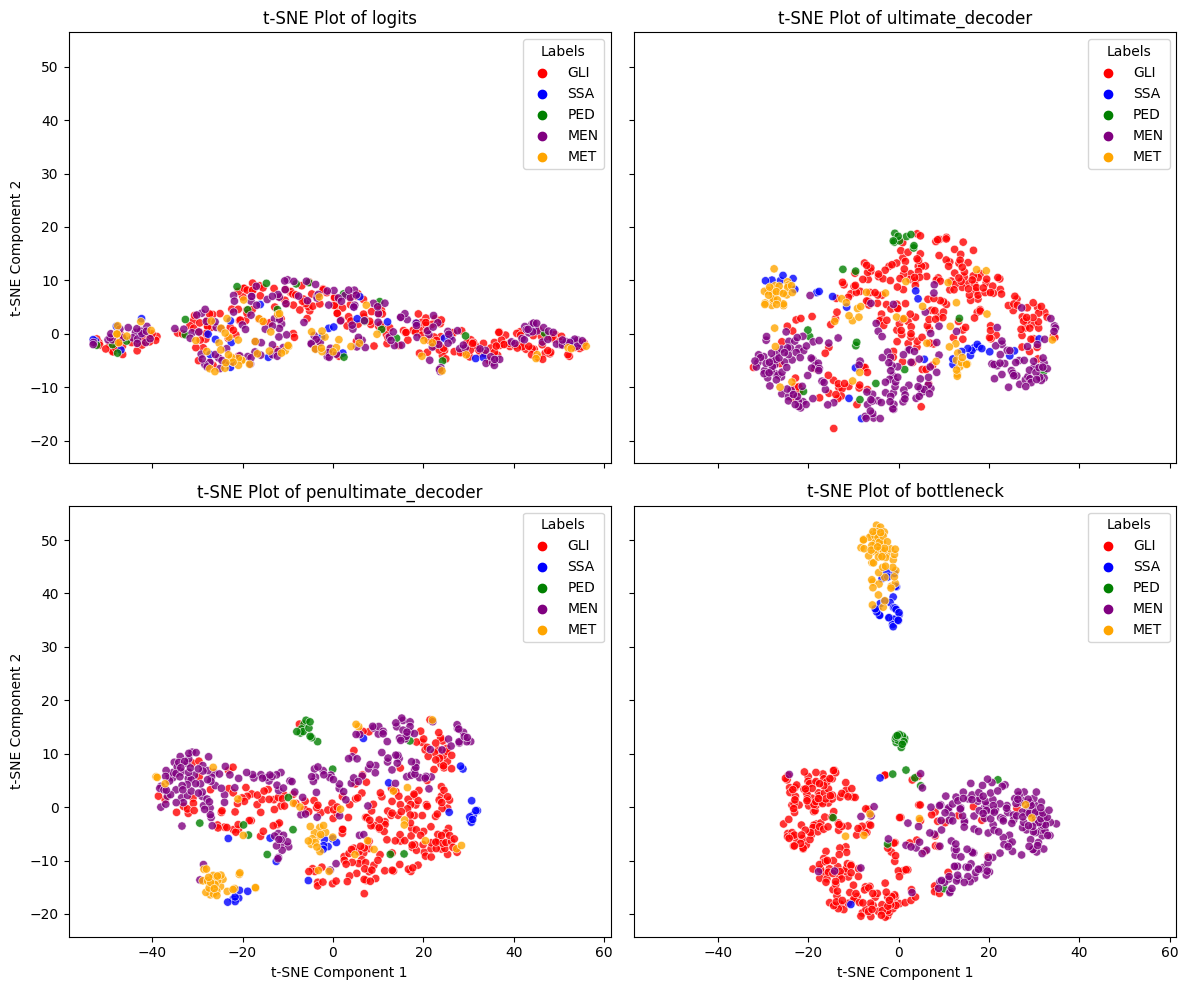

In [10]:
path = Path('/kaggle/input/final_kd_student_model/pytorch/default/2/Final_KD_Student_Model_v2.pth')
model = load_model(path)

features = extract_features(model, testLoader, path)
tsne_analysis(features)